In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have DataFrames in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added DataFrames as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading DataFrames into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [3]:
using ForneyLab
using BenchmarkTools
using Random
using LinearAlgebra

In [4]:
import Distributions

In this section we want to compare results and performance of ReactiveMP.jl with another probabilistic programming library which is called ForneyLab.jl.

In [5]:
params = let 
    seed = 42
    n    = 250
    d    = 3

    rng = MersenneTwister(seed)

    A = random_rotation_matrix(rng, d)
    B = Matrix(Diagonal(ones(d) .+ rand(-0.5:0.1:1.0, d)))
    P = Matrix(Diagonal(ones(d)))
    Q = Matrix(Diagonal(ones(d)))

    @strdict seed n d A B P Q
end;

In [6]:
x_data, y_data = generate_data(LGSSMModel(), params);

In [7]:
g = FactorGraph()

model_d = params["d"]
model_n = params["n"]
model_A = params["A"]
model_B = params["B"]
model_P = params["P"]
model_Q = params["Q"]

@RV x0 ~ GaussianMeanVariance(zeros(model_d), Matrix(Diagonal(100.0 * ones(model_d)))) # Prior

x = Vector{Variable}(undef, model_n) # Pre-define vectors for storing latent and observed variables
y = Vector{Variable}(undef, model_n)

x_t_prev = x0

for t = 1:model_n
    @RV x[t] ~ GaussianMeanVariance(model_A*x_t_prev, model_P) # Process model
    @RV y[t] ~ GaussianMeanVariance(model_B*x[t], model_Q) # Observation model

    placeholder(y[t], :y, dims=(model_d,), index=t) # Indicate observed variable
    
    x_t_prev = x[t] # Prepare state for next section
end
;

In [8]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 99.221951 seconds (15.54 M allocations: 6.174 GiB, 1.18% gc time, 3.25% compilation time)


step! (generic function with 3 methods)

In [9]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 92.673063 seconds (10.62 M allocations: 5.887 GiB, 1.08% gc time)


step! (generic function with 3 methods)

In [10]:
# For DIMENSION = 2

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 25.956291 seconds (2.87 M allocations: 1.646 GiB, 1.31% gc time)
# 100 - 50.820114 seconds (5.79 M allocations: 3.319 GiB, 1.33% gc time)
# 250 - 134.148255 seconds (15.09 M allocations: 8.506 GiB, 1.31% gc time)

In [11]:
# For DIMENSION = 3

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 26.739488 seconds (2.97 M allocations: 1.655 GiB, 1.31% gc time)
# 100 - 52.731018 seconds (5.98 M allocations: 3.345 GiB, 1.27% gc time)
# 250 - 131.314365 seconds (15.12 M allocations: 8.608 GiB, 1.30% gc time)

In [12]:
# For DIMENSION = 4

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 26.431713 seconds (2.98 M allocations: 1.664 GiB, 1.40% gc time)
# 100 - 53.235425 seconds (5.82 M allocations: 3.361 GiB, 1.22% gc time)
# 250 - 134.367599 seconds (15.16 M allocations: 8.743 GiB, 1.30% gc time)

In [13]:
data = Dict(:y => y_data) # Prepare data dictionary
;

In [14]:
@time step!(data);

530.264025 seconds (23.53 M allocations: 1.279 GiB, 0.10% gc time, 99.99% compilation time)


In [15]:
# For DIMENSION = 2

# ForneyLab compilation time
# 50 - 14.220841 seconds (1.65 M allocations: 74.833 MiB, 99.98% compilation time)
# 100 - 58.928251 seconds (3.17 M allocations: 139.763 MiB, 0.07% gc time, 99.99% compilation time)
# 250 - 517.620802 seconds (7.74 M allocations: 332.614 MiB, 0.02% gc time, 100.00% compilation time)

In [16]:
# For DIMENSION = 3

# ForneyLab compilation time
# 50 - 14.103068 seconds (1.74 M allocations: 79.730 MiB, 99.98% compilation time)
# 100 - 64.041207 seconds (3.22 M allocations: 141.569 MiB, 0.04% gc time, 99.99% compilation time)
# 250 - 543.978409 seconds (7.85 M allocations: 337.028 MiB, 0.03% gc time, 99.99% compilation time)

In [17]:
# For DIMENSION = 4

# ForneyLab compilation time
# 50 - 15.279364 seconds (1.70 M allocations: 76.835 MiB, 0.18% gc time, 99.98% compilation time)
# 100 - 60.076357 seconds (3.28 M allocations: 143.701 MiB, 0.04% gc time, 99.99% compilation time)
# 250 - 533.756807 seconds (8.00 M allocations: 342.367 MiB, 0.03% gc time, 99.99% compilation time)

In [18]:
@time step!(data);

  0.012767 seconds (99.60 k allocations: 11.003 MiB)


In [19]:
@time step!(data);

  0.011578 seconds (99.60 k allocations: 11.003 MiB)


In [20]:
@btime step!(data);

  9.157 ms (99600 allocations: 11.00 MiB)


In [21]:
inferred = step!(data) # Execute inference
marginals = map(i -> inferred[Symbol(:x_, i)], 1:model_n) 
;

In [23]:
average_mse(x_data, marginals) ./ length(x_data)

1.844529640272791

In [323]:
# For DIMENSION = 2

# ForneyLab execution times and E[MSE]
# 50 - 1.503 ms (19742 allocations: 2.07 MiB) | E[MSE] = 88.22147515569644
# 100 - 3.235 ms (39642 allocations: 4.15 MiB) | E[MSE] = 186.83166789346208
# 250 - 8.166 ms (99600 allocations: 10.42 MiB) | E[MSE] = 466.9194488439762

In [324]:
# For DIMENSION = 3

# ForneyLab execution times and E[MSE]
# 50 - 1.642 ms (19742 allocations: 2.19 MiB) | E[MSE] = 152.19541017518787
# 100 - 3.954 ms (39642 allocations: 4.39 MiB) | E[MSE] = 294.0329174204192
# 250 - 8.952 ms (99600 allocations: 11.00 MiB) | E[MSE] = 685.7877512757051

In [325]:
# For DIMENSION = 4

# ForneyLab execution times and E[MSE]
# 50 - 1.783 ms (19742 allocations: 2.30 MiB) | E[MSE] = 193.49009551500487
# 100 - 3.628 ms (39642 allocations: 4.60 MiB) | E[MSE] = 362.03089108526143
# 250 - 9.624 ms (99600 allocations: 11.55 MiB) | E[MSE] = 910.8783299156165

In [326]:
using CairoMakie

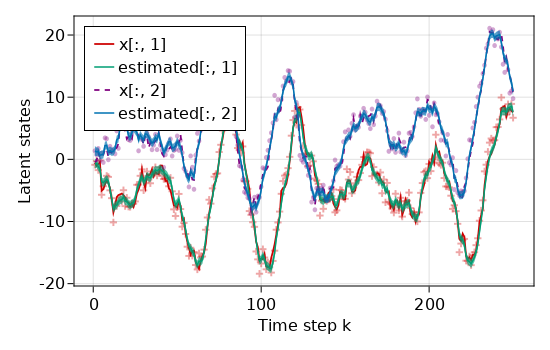

In [327]:
let
    c = Makie.wong_colors() 

    x_inferred_means = ForneyLab.unsafeMean.(marginals)
    x_inferred_stds  = map(e -> sqrt.(e), ForneyLab.unsafeVar.(marginals))
    
    range = 1:length(x_inferred_means)

    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    # Real dim1
    lines!(ax, range, x_data |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]",)
    scatter!(ax, range, y_data |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_data |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_data |> edim(2), color = (:purple, 0.35),markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt)

    fig
end